# Agent 

本节将介绍 Autogen 的 Agent 部分，包含：

- Autogen 的各种常用预设 Agent
- 如何调用定义的 Agent 进行各种操作。
- 如何使用 Autogen 定制自己的 Agent

参考资料：https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/tutorial/agents.html

配置 LLM Api

参考 `Client.ipynb`

In [ ]:
import os
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.messages import TextMessage
load_dotenv()
siliconflow_api_key = os.getenv("SILICONFLOW_API_KEY") # 读取你的 OPENAI API key
if not siliconflow_api_key:
    raise ValueError("SILICONFLOW_API_KEY environment variable is required")
else:
    print("successfully loaded siliconflow api key")

# 初始化 OpenAIChatCompletionClient 客户端，连接到硅基流动平台的 Qwen3-8B 模型
model_client = OpenAIChatCompletionClient(
    model="Qwen/Qwen3-8B",                # 指定要调用的模型名称，硅基流动平台上 Qwen 3-8B 模型
    base_url="https://api.siliconflow.cn/v1",  # 硅基流动平台的 API 访问地址
    api_key=siliconflow_api_key,  # 你的 API 密钥
    model_info={                        
        "family": "qwen",              
        "context_length": 8192,        
        "max_output_tokens": 2048,     
        "tool_choice_supported": True, 
        "tool_choice_required": False,  
        "structured_output": True,     
        "vision": False,                
        "function_calling": True,      
        "json_output": True ,         
        "stream" : True
    },
)

successfully loaded siliconflow api key


## Agent 介绍

`AutoGen` 的 `AgentChat` 类 提供了一组预设 **Agent** ，用于不同类型的对话任务。每个 Agent 都实现了独立的消息生成逻辑或行为模式，支持灵活构建复杂的多智能体协作系统。以下列举了所有 Agent 共享的部分常用属性与方法：

**共有属性：**

- `name`: Agent 的唯一标识符，用于区分不同 Agent 实例。（必选）

- `description`: 对该 Agent 的简要描述，用于解释用途或角色。（可选）

- `system_message`: 初始化时发送给模型的系统提示词，影响 Agent 回复风格、角色设定等。（可选）

- `llm_config`: 底层大模型配置（可选）

**共有方法**

- `run`: 处理新任务或消息 → 返回完整结果 `TaskResult`。**仅处理新输入，不负责维护对话历史。**

  其中run方法需要传入的参数：

| 参数名          | 类型       | 必选 | 默认值       | 作用                                                                 |
|-----------------|------------|------|--------------|----------------------------------------------------------------------|
| `task`          | `str`      | 是   | -            | 需要 Agent 执行的任务描述（如 `"计算 1+1"`）。                       |
| `clear_history` | `bool`     | 否   | `False`      | 是否在执行前清空对话历史（避免上下文干扰）。                         |
| `function_call` | `dict`/`str` | 否  | `None`       | 指定要调用的工具函数（如 `{"name": "calculator", "parameters": {"a": 1, "b": 1}}`）。 |
| `**kwargs`      | 可变参数   | 否   | -            | 其他传递给 LLM 的参数（如 `temperature`、`max_tokens` 等）。         |
 

- `run_stream`: 是 `run()` 的增强版本，流式处理任务 → 边生成边返回消息流，最后返回 `TaskResult`。适合实时输出场景。

  其中run_stream方法需要传入的参数：

| 参数名          | 类型       | 必选 | 默认值       | 作用                                                                 |
|-----------------|------------|------|--------------|----------------------------------------------------------------------|
| `task`          | `str`      | 是   | -            | 需要 Agent 执行的任务描述（如 "解释机器学习"）。                     |
| `clear_history` | `bool`     | 否   | `False`      | 是否在执行前清空对话历史（避免上下文干扰）。                         |
| `function_call` | `dict`/`str` | 否  | `None`       | 指定要调用的工具函数（格式同 `run`）。                               |
| `stream`        | `bool`     | 否   | `True`       | 是否启用流式输出（若为 `False`，则等同于 `run`）。                   |
| `**kwargs`      | 可变参数   | 否   | -            | 其他传递给 LLM 的参数（如 `temperature`、`max_tokens` 等）。         |

> 上面两者的区别：
> - `run()`：一次性返回完整 `TaskResult` 。
> - `run_stream()`：边生成边返回消息流，最后再返回 `TaskResult` 。

其中 TaskResult 返回的内容包括：Client使用过mseeages信息，这存储了智能体的思考过程和最终的回复，接下来我将在下面的例子中简要分析智能体的返回内容是如何反映其思考过程的。

在下面的例子中会详细介绍具体的使用方法。


## Autogen 的预设 Agent

将按照下面的顺序进行讲解：

- AssistantAgent
- UserProxyAgent
- MessageFilterAgent
- SocietyOfMindAgent
- RetrievalAgent

### Assistant Agent

**AssistantAgent** 是 AutoGen 框架中最基础、最常用的智能体（Agent）类型。它的核心作用是作为“助手”与用户或其他 Agent 进行对话，理解任务、生成回复，并可根据需要调用外部工具（如函数、API）来辅助完成复杂任务。继承自 `ConversableAgent`


**主要功能**

- **自然语言对话**：能够理解用户输入并生成自然语言回复。
- **工具调用**：可集成外部函数、API，实现联网搜索、计算、数据处理等扩展能力。
- **系统提示（System Message）**：支持自定义智能体的角色和行为风格。
- **多轮对话**：支持上下文记忆，能够进行多轮连续对话。
- **与其他 Agent 协作**：可作为多智能体系统中的一员，与其他 Agent 协同工作。


**参数说明**

| 参数名           | 说明                                                         |
|------------------|--------------------------------------------------------------|
| `name`           | Agent 名称，便于区分多个 Agent                               |
| `model_client`   | 绑定的 LLM 客户端（如 OpenAI、OpenRouter 等）                |
| `tools`          | 可选，外部工具列表（如函数、API），用于扩展 Agent 能力        |
| `system_message` | 可选，系统提示词，定义 Agent 的角色、风格、行为等  |



In [3]:
from autogen_agentchat.agents import AssistantAgent

# 示例：不带工具，仅对话
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    system_message="你是一个乐于助人的中文助手。"
)

In [4]:
result = await agent.run(task="请介绍一下AutoGen框架。")
print(result.messages)  # 输出对话消息内容

[TextMessage(id='c7ad07f8-0ea9-4249-8a7b-3491f23089b1', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 15, 7, 55, 51, 385778, tzinfo=datetime.timezone.utc), content='请介绍一下AutoGen框架。', type='TextMessage'), ThoughtEvent(id='e39bfeb7-8052-41f4-aab0-3200ac902c8f', source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 15, 7, 56, 42, 404990, tzinfo=datetime.timezone.utc), content='\n好的，我现在需要介绍AutoGen框架。首先，我得确定用户对AutoGen的了解程度，可能他们刚接触这个领域，或者已经有一些基础。用户的问题是直接要介绍，所以我应该从概述开始，说明AutoGen是什么，它的主要用途，以及它的特点。\n\n接下来，我需要回忆AutoGen的基本信息。AutoGen是一个由微软研究院开发的框架，用于构建多智能体对话系统，支持自动化生成对话流程。它应该和传统的对话系统不同，可能更注重自动化和协作。然后，要提到它基于LangChain等库，这样用户知道它的底层技术。\n\n然后，结构方面，AutoGen使用Actor-Critic框架，这可能涉及到强化学习的概念。用户可能对这个术语不太熟悉，需要简单解释。另外，像Ragas这样的评估工具，可能用户需要知道如何去评估模型效果。\n\n需要分点说明，比如核心功能、技术特点、应用场景、优势等。确保每个部分清晰明了。核心功能方面，多智能体协作、自动化对话流程、支持多种模型和插件，以及任务分解。技术特点包括动态角色分配、多轮对话、模块化设计、集成评估工具，以及灵活的插件系统。应用场景可能涉及客服、教育、数据分析等。优势是灵活性、可扩展性、协作性、集成评估、社区支持。\n\n还要注意用户可能的深层需求，比如他们是

上述未调用工具智能体返回的消息列表记录了 用户请求-智能体思考-智能体响应 的完整对话流程，体现了 AutoGen 框架中智能体的 自主决策能力 和 结构化内容生成能力。

### 消息详情解析

1. 用户请求（TextMessage）
content = "请介绍一下AutoGen框架。"
说明：用户明确要求智能体介绍 AutoGen 框架，是交互的起点。

2. 智能体思考过程（ThoughtEvent）
分析历史交互：
首次调用web_search工具返回的结果过于简略（仅 "AutoGen 是一个多智能体协作框架"）。
用户再次提问，推测需要更全面的解释（功能、应用场景、技术特点等）...

3. 智能体响应（TextMessage）
结构化内容：
AutoGen 是由微软研究院开发的多智能体协作框架...



---

In [4]:
# 示例：带工具，具备联网搜索能力
from autogen_agentchat.agents import AssistantAgent

#注意定义工具函数的时候常常使用异步函数
async def web_search(query: str) -> str:
    return "AutoGen 是一个多智能体协作框架。"

agent_with_tool = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="要求对于用户询问的所有问题必须使用工具来解决问题"
)

In [5]:
result = await agent_with_tool.run(task="请介绍一下AutoGen框架。")
print(result) #我们看一下智能体返回的内容都有什么

messages=[TextMessage(id='72d60a3a-485b-471a-967a-b6b3883ed198', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 15, 6, 26, 39, 312947, tzinfo=datetime.timezone.utc), content='请介绍一下AutoGen框架。', type='TextMessage'), ThoughtEvent(id='af45770e-4c2b-430a-818f-6ee720d0fa39', source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 15, 6, 26, 48, 475293, tzinfo=datetime.timezone.utc), content='\n\n', type='ThoughtEvent'), ToolCallRequestEvent(id='4a7c9e98-e083-4ab1-b4b8-ab222088debc', source='assistant', models_usage=RequestUsage(prompt_tokens=179, completion_tokens=362), metadata={}, created_at=datetime.datetime(2025, 7, 15, 6, 26, 48, 475333, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='01980cc3b0d9f83aebc1717386ce8272', arguments=' {"query": "AutoGen框架 介绍"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(id='d56f32c0-3084-4f65-984c-bd4dbd479c01', source='assistant', models_usage=N

上述消息列表展示了使用 AutoGen 框架实现的智能体调用外部工具的完整流程。
### 消息列表详情
1. #### 用户请求：
TextMessage(
    source='user', 
    content='请介绍一下AutoGen框架。'
)

用户发起了对 AutoGen 框架的介绍请求。

2. #### 智能体思考：
ThoughtEvent(
    source='assistant', 
    content='\n\n'
)

这里的思考内容为空，但在实际场景中，智能体可能会规划如何处理这个请求。

3. #### 工具调用请求：
ToolCallRequestEvent(
    source='assistant',
    content=[FunctionCall(
        name='web_search',
        arguments=' {"query": "AutoGen框架介绍"}'
    )]
)

智能体决定调用web_search工具来获取关于 AutoGen 框架的信息，参数为查询关键词。

4. #### 工具执行结果：
ToolCallExecutionEvent(
    source='assistant',
    content=[FunctionExecutionResult(
        content='AutoGen 是一个多智能体协作框架。',
        name='web_search',
        call_id='0197bae8e78c23d46afe2ec81f204907'
    )]
)

web_search工具返回执行结果，提供了关于 AutoGen 框架的基本定义。

5. #### 结果摘要：
ToolCallSummaryMessage(
    source='assistant',
    content='AutoGen 是一个多智能体协作框架。'
)

智能体将工具返回的内容整理为摘要，这可能会作为最终回复的一部分。

---

### UserProxyAgent

**UserProxyAgent** 是 AutoGen 框架中用于模拟“用户”角色的智能体。它的主要作用是作为人类用户的代理，参与多智能体协作流程，驱动对话和任务的发起。  在多智能体系统中，UserProxyAgent 通常作为“入口”，负责输入任务、问题或指令，并与其他 Agent 互动。

> 简单来说，这个 Agent 就是来充当 Agent Workflow 中的 用户，模拟人类输出对话。


**主要功能**


- **模拟用户输入**：可以自动或手动输入消息，驱动对话流程。
- **流程控制**：可配置为自动继续、等待人工输入或终止对话。
- **与其他 Agent 协作**：作为多智能体协作中的“人类代理”，与助手、审查等 Agent 互动。


**应用场景**

- 多智能体协作流程的“用户入口”
- 自动化测试（模拟用户行为）
- 需要人工参与的多轮对话系统


| 参数名         | 说明                                                                                   |
|----------------|----------------------------------------------------------------------------------------|
| `name`         | Agent 名称，便于区分多个 Agent                                                         |
| `description`  | 可选，描述信息，默认为 `'A human user'`                                                |
| `input_func`   | 可选，自定义输入函数。可以是同步或异步函数，实现自动输入或自定义输入逻辑                 |


**注意事项**

- `human_input_mode` 决定了是否需要人工输入，适合不同的自动化或交互需求。
- 通常与 AssistantAgent、CriticAgent 等其他 Agent 配合使用。

参考：https://microsoft.github.io/autogen/dev/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.UserProxyAgent


In [6]:
# （1）默认用法（人工输入）
from autogen_agentchat.agents import UserProxyAgent

user_agent = UserProxyAgent(
    name="user",
    description="你是一个用户。"
)

In [7]:
# （2）自动输入（模拟用户，无需人工参与）

from autogen_agentchat.agents import UserProxyAgent

def my_input(prompt):
    return "这是自动输入的内容"

user_agent = UserProxyAgent(
    name="user",
    input_func=my_input
)
# 运行时会自动返回内容，无需人工输入

In [8]:
# （3）异步自动输入
import asyncio
from autogen_agentchat.agents import UserProxyAgent

async def my_async_input(prompt, cancellation_token=None):
    await asyncio.sleep(1)
    return "异步输入内容"

user_agent = UserProxyAgent(
    name="user",
    input_func=my_async_input
)

### MessageFilterAgent
注意：请升级库版本到0.6.2以使用该库，官方文档中写道："这是一项实验性功能，API 将在未来版本中进行修改。"

封装代理，用于在将传入信息传递给内部代理之前对其进行过滤。

    这在多代理工作流等场景中非常有用，在这些场景中，代理只需
    处理完整消息历史记录的子集--例如，只处理来自每个上游代理的最后一条消息，或只处理来自每个上游代理的最后一条消息。
    例如，只处理来自每个上游代理的最后一条消息，或只处理来自特定来源的第一条消息。

    过滤是通过 :class:`MessageFilterConfig` 配置的，它支持
    - 按消息源过滤（例如，只过滤来自 "用户 "或其他代理的消息）
    - 从每个消息源中选择前 N 条或后 N 条消息
    - 如果位置为 "无"，则包括来自该来源的所有信息

该代理与直接信息传递和基于团队的执行都兼容
例如 :class:`~autogen_agentchat.teams.GraphFlow`.

在下面我们举的例子中，您希望
- A 只能看到用户信息和来自 B 的最后一条信息
- B 查看用户信息、来自 A 的最后一条信息以及自己之前的回复（用于反思）
- C 查看用户信息和来自 B 的最后一条信息

下面我们将给出参考代码说明如何利用MessageFilterAgent实现上述要求

In [ ]:
import asyncio
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import  MessageFilterAgent

# 配置消息过滤代理
agent_a = MessageFilterAgent(
    name="A",
    wrapped_agent=agent_a_inner,
    filter=MessageFilterConfig(
        per_source=[
            PerSourceFilter(source="user", position="first", count=1),
            PerSourceFilter(source="B", position="last", count=1),
        ]
    ),
)

agent_b = MessageFilterAgent(
    name="B",
    wrapped_agent=agent_b_inner,
    filter=MessageFilterConfig(
        per_source=[
            PerSourceFilter(source="user", position="first", count=1),
            PerSourceFilter(source="A", position="last", count=1),
            PerSourceFilter(source="B", position="last", count=10),
        ]
    ),
)

agent_c = MessageFilterAgent(
    name="C",
    wrapped_agent=agent_c_inner,
    filter=MessageFilterConfig(
        per_source=[
            PerSourceFilter(source="user", position="first", count=1),
            PerSourceFilter(source="B", position="last", count=1),
        ]
    ),
)

# 定义多智能体交互图
graph = DiGraph(
    nodes={
        "A": DiGraphNode(name="A", edges=[DiGraphEdge(target="B")]),
        "B": DiGraphNode(
            name="B",
            edges=[
                DiGraphEdge(target="C", condition="exit"),
                DiGraphEdge(target="A", condition="loop"),
            ],
        ),
        "C": DiGraphNode(name="C", edges=[]),
    },
    default_start_node="A",
)

通过以上的处理后，我们确保每个代理只看到其决策或操作逻辑所需的内容。

### SocietyOfMindAgent 

`SocietyOfMindAgent` 是 Autogen 框架中一个具有独特设计的智能体类，其核心思想是通过 "内部团队" 的多个智能体协作来生成最终响应。即将解决复杂问题转换为通过多个简单组件的协作来解决。

该类继承自 BaseChatAgent 和 Component[SocietyOfMindAgentConfig]，兼具智能体功能和组件配置管理能力。其核心特点是每次接收到消息时，会运行内部团队智能体进行协作，然后基于团队的交互结果生成最终响应。

参数：

name(str) -智能体的名称。

team(Team)-要使用的智能体Team。

model_client(ChatCompletionClient)-用于准备响应的client。

description(str,optional)-智能体的描述。

instruction(str,optional)-使用内部团队的消息生成响应时使用的指令。 默认的，该智能体承担了“系统”的角色。

response_prompt(str,optional)-使用内部团队的消息生成响应时使用的响应提示符。 默认为。它承担了“系统”的角色。

model_context(ChatCompletionContext | none,optional)-用于存储和检索的模型上下文。它可以预先加载初始消息。当代理被重置时，初始消息将被清除。

我们简单举一个例子

In [10]:
import asyncio
from autogen_agentchat.ui import Console
from autogen_agentchat.agents import AssistantAgent, SocietyOfMindAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.conditions import TextMentionTermination
import nest_asyncio  # 新增：解决嵌套循环问题

# 应用nest_asyncio补丁
nest_asyncio.apply()

async def main() -> None:
    agent1 = AssistantAgent("assistant1", model_client=model_client, system_message="You are a writer, write well.")
    agent2 = AssistantAgent(
        "assistant2",
        model_client=model_client,
        system_message="You are an editor, provide critical feedback. Respond with 'APPROVE' if the text addresses all feedbacks.",
    )
    inner_termination = TextMentionTermination("APPROVE")
    inner_team = RoundRobinGroupChat([agent1, agent2], termination_condition=inner_termination ,max_turns=4)

    society_of_mind_agent = SocietyOfMindAgent("society_of_mind", team=inner_team, model_client=model_client)

    agent3 = AssistantAgent(
        "assistant3", model_client=model_client, system_message="Translate the text to Spanish."
    )
    team = RoundRobinGroupChat([society_of_mind_agent, agent3], max_turns=2)

    stream = team.run_stream(task="Write a short story with a surprising ending.")
    await Console(stream)


# 仅在顶层调用一次asyncio.run
if __name__ == "__main__":
    asyncio.run(main())


---------- TextMessage (user) ----------
Write a short story with a surprising ending.
---------- ThoughtEvent (assistant1) ----------

Okay, the user wants a short story with a surprising ending. Let me think about how to approach this. First, I need to create a compelling narrative that builds up to the twist. Maybe start with a relatable situation or a character that the reader can connect with. Let's see... Perhaps a character who is trying to escape a mundane life. 

Hmm, the setting could be a small town to create a sense of isolation. Maybe the protagonist is someone who's been stuck there for a while, like a librarian. That's a quiet, observant role which can lead to interesting discoveries. 

Now, the surprise ending. It needs to be unexpected but also plausible. Maybe the town isn't real? Or perhaps the protagonist is in a simulation? Wait, the user might want something more grounded. Let me think... What if the town is actually a place where time moves differently? Or maybe 

我们可以这样理解：对于一个询问的message，SocietyOfMindAgent首先会将其交给其中的team进行解决，然后将team回复过程中生成的messages作为他的模型client的上下文内容进行一个总结，
比如上述例子中：当助手1和助手2协同写出这个故事后，SocietyOfMindAgent会将team协同的messages作为模型上下文内容输入给助手3，让助手3的模型对最终内容进行翻译。

接下来我们介绍自带功能的agent：
 
1. MultimodalWebSurfer

这是一个多模态Agent，他可以搜索网络和访问网页，自动化的网页操作与信息获取。

#### MultimodalWebSurfer

以下是整理好的 `MultimodalWebSurfer` 类参数说明 Markdown 表格：

| 参数名                | 类型                  | 说明                                                         | 默认值                          |
| --------------------- | --------------------- | ------------------------------------------------------------ | ------------------------------- |
| `name`                | `str`                 | 智能体（agent）的名称，用于区分不同智能体，方便多智能体协作场景识别 | -（需用户传入具体名称）         |
| `model_client`        | `ChatCompletionClient` | 智能体使用的模型客户端，必须支持多模态和工具调用能力，负责与大模型交互 | -（需用户传入适配的客户端实例） |
| `downloads_folder`    | `str \| None`         | 网页交互中下载文件的保存目录，`None` 表示不保存下载内容      | `None`                          |
| `description`         | `str`                 | 智能体的描述信息，用于说明其功能角色                         | `MultimodalWebSurfer.DEFAULT_DESCRIPTION` |
| `debug_dir`           | `str \| None`         | 存放调试信息（如操作日志等）的目录，`None` 表示不保存调试信息 | `None`                          |
| `headless`            | `bool`                | 控制浏览器是否以无头模式（无可视化界面）运行，`True` 为无头模式，适合自动化任务；`False` 会弹出浏览器窗口 | `True`                          |
| `start_page`          | `str \| None`         | 浏览器启动后默认打开的初始页面                               | `MultimodalWebSurfer.DEFAULT_START_PAGE` |
| `animate_actions`     | `bool`                | 是否为浏览器操作（点击、滚动等）添加动画效果，`True` 会让操作更贴近人工交互视觉效果，常用于调试 | `False`                         |
| `to_save_screenshots` | `bool`                | 是否保存网页截图，可用于记录交互过程、辅助调试等             | `False`                         |
| `use_ocr`             | `bool`                | 是否启用 OCR（光学字符识别）功能，识别网页图片里的文字内容   | `False`                         |
| `browser_channel`     | `str \| None`         | 指定浏览器通道，一般用于特殊版本或测试场景，`None` 用默认通道 | `None`                          |
| `browser_data_dir`    | `str \| None`         | 浏览器数据（缓存、Cookie 等）的存储目录，`None` 用临时或默认存储位置 | `None`                          |
| `to_resize_viewport`  | `bool`                | 是否自动调整浏览器视口大小，让页面展示更符合预期             | `True`                          |
| `playwright`          | `Playwright \| None`  | 预初始化的 `Playwright` 实例，若已有全局配置可传入复用，`None` 则内部自动初始化 | `None`                          |
| `context`             | `BrowserContext \| None` | 浏览器上下文（自定义 Cookie、权限等设置），`None` 用默认上下文 | `None`                          |

在实际初始化 `MultimodalWebSurfer` 时，根据需求针对性设置这些参数 。 

注意： DEFAULT_START_PAGE = "https://www.bing.com/"
以下是其使用实例：

In [11]:
import sys
import asyncio

# 强制设置事件循环（必须在最顶部）
if sys.platform == "win32":
    asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())

from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.agents.web_surfer import MultimodalWebSurfer

async def main():
  
    # 直接创建智能体并运行（不通过团队）
    web_surfer = MultimodalWebSurfer(
        name="test_surfer",
        model_client=model_client,
        headless=False
    )
    
    # 直接运行任务
    result = await web_surfer.run(task="Navigate to https://github.com/microsoft/autogen/blob/main/README.md")
    print(result)
    await web_surfer.close()


await main()

messages=[TextMessage(id='a96c627e-e13d-47fe-b6f4-46c6dcd455a6', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 15, 6, 32, 55, 235173, tzinfo=datetime.timezone.utc), content='Navigate to https://github.com/microsoft/autogen/blob/main/README.md', type='TextMessage'), TextMessage(id='22bb2a0e-fcd5-4b42-a84a-6692528d8abc', source='test_surfer', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 15, 6, 33, 5, 362344, tzinfo=datetime.timezone.utc), content='visit_url( {"reasoning": "Navigating to the specified GitHub repository README.md file.", "url": "https://github.com/microsoft/autogen/blob/main/README.md"} )', type='TextMessage'), MultiModalMessage(id='136e516e-453f-470c-8fd8-61484b2c228b', source='test_surfer', models_usage=RequestUsage(prompt_tokens=1569, completion_tokens=279), metadata={}, created_at=datetime.datetime(2025, 7, 15, 6, 33, 11, 949116, tzinfo=datetime.timezone.utc), content=['I typed \'https://github.com/microso

## Agent 的操作

本部分示例全部使用 Assistant Agent 进行演示。

### 得到执行结果 Get Result

使用方法 `run()` 得到Agent的执行结果。


In [ ]:
# Use asyncio.run(agent.run(...)) when running in a script.
result = await agent.run(task="Find information on AutoGen")
print(result.messages)

调用 `run()` 方法时，Agent 会自动更新其内部状态 —— 也就是说，`run()` 会把本次交互的消息加入到 Agent 的消息历史中。  你还可以在不传递新任务（task）的情况下调用 `run()`，此时 Agent 会基于当前的历史状态生成回复。这种方式适合多轮对话或让 Agent 根据上下文继续推理和输出。

In [ ]:
await agent.run()

### Tool_Call机制和如何设置只能调用工具的智能体 

这一部分我们将在介绍智能体从用户输入task到调用工具到输出结果的过程，以方便你更好的了解Tool_Call机制，从而能够设置一个只调用工具的智能体。

为了更好的了解其中的过程，强烈建议你在IDE中对代码打断点观察程序运行中的全局变量和局部变量以及代码逻辑。我们将在Pycharm中进行演示。

想要更详细的信息请参考：https://microsoft.github.io/autogen/stable/_modules/autogen_agentchat/agents/_assistant_agent.html#AssistantAgent

Demo代码如下，请复制到IDE中运行
：

In [1]:
def get_weather():
    return "明天的平均气温是30摄氏度"

async def main():
    Weatheragent = AssistantAgent(
        name="天气预报员",
        model_client=QWEN_VL_client,  #这里需要自己配置
        tools=[get_weather],
        system_message="必须使用工具回答我的问题"
    )
    output_message = await Weatheragent.run(task="明天的天气怎么样？")
    print(output_message)


if __name__ == "__main__":
    asyncio.run(main())

NameError: name 'asyncio' is not defined

首先，我们需要了解.run()代码，所以直接看.run()的其中和我们探讨内容有关的源代码（run()的代码在AssistantAgent基类中）：

In [1]:
 async def run(
        self,
        *,
        task: str | BaseChatMessage | Sequence[BaseChatMessage] | None = None,
        cancellation_token: CancellationToken | None = None,
        output_task_messages: bool = True,
    ) -> TaskResult:
        """Run the agent with the given task and return the result."""
        with trace_invoke_agent_span(
            agent_name=self.name,
            agent_description=self.description,
        ):
            #....这里进行了input_message和output_message的初始化
            response = await self.on_messages(input_messages, cancellation_token)  # 这里的on_messages是处理task的关键
            
            if response.inner_messages is not None:
                output_messages += response.inner_messages
            output_messages.append(response.chat_message)
            return TaskResult(messages=output_messages)

NameError: name 'BaseChatMessage' is not defined

依次类推，我们只关注源代码中有关处理Task的关键代码，当你点进去`on_messages()`观察后，发现实现Task完成代码又在另一个函数`on_messages_stream()`中，这个函数是Task处理

的核心函数。

根据官方文档，该函数处理的流程为：

1. Add new user/handoff messages to the model context

2. Update model context with any relevant memory 

3. Generate a message ID for correlation between streaming chunks and final message

4. Run the first inference

5. Tool_Call_judge

前三步不包含核心处理逻辑，我们着重看第四步和第五步的代码，以下是官方文档源代码：

In [ ]:
 # STEP 4: Run the first inference
        model_result = None
        async for inference_output in self._call_llm(   #-----------------------1
            model_client=model_client,
            model_client_stream=model_client_stream,
            system_messages=system_messages,
            model_context=model_context,
            workbench=workbench,
            handoff_tools=handoff_tools,
            agent_name=agent_name,
            cancellation_token=cancellation_token,
            output_content_type=output_content_type,
            message_id=message_id,
        ):
            if isinstance(inference_output, CreateResult):
                model_result = inference_output
            else:
                # Streaming chunk event
                yield inference_output

        assert model_result is not None, "No model result was produced."

        # --- NEW: If the model produced a hidden "thought," yield it as an event ---
        if model_result.thought:
            thought_event = ThoughtEvent(content=model_result.thought, source=agent_name)
            yield thought_event
            inner_messages.append(thought_event)

        # Add the assistant message to the model context (including thought if present)
        await model_context.add_message(
            AssistantMessage(
                content=model_result.content,
                source=agent_name,
                thought=getattr(model_result, "thought", None),
            )
        )

        # STEP 5: Process the model output
        async for output_event in self._process_model_result( #---------------2
            model_result=model_result,
            inner_messages=inner_messages,
            cancellation_token=cancellation_token,
            agent_name=agent_name,
            system_messages=system_messages,
            model_context=model_context,
            workbench=workbench,
            handoff_tools=handoff_tools,
            handoffs=handoffs,
            model_client=model_client,
            model_client_stream=model_client_stream,
            reflect_on_tool_use=reflect_on_tool_use,
            max_tool_iterations=max_tool_iterations,
            tool_call_summary_format=tool_call_summary_format,
            tool_call_summary_formatter=tool_call_summary_formatter,
            output_content_type=output_content_type,
            message_id=message_id,
            format_string=self._output_content_type_format,
        ):
            yield output_event

首先看到上面我注释的函数1和2，由于前面的转换，函数1的输入核心其实就是我们的Task，函数1的结果是函数2的核心输入，点开函数2后能发现，函数2的输入决定是否调用Tool。

这下思路就明确了，我们先看函数2怎么判断是否调用Tool的，函数2部分关键源代码如下：


In [ ]:
 # Otherwise, we have function calls
            assert isinstance(current_model_result.content, list) and all(
                isinstance(item, FunctionCall) for item in current_model_result.content
            )#----------------判断条件

            # STEP 4A: Yield ToolCallRequestEvent
            tool_call_msg = ToolCallRequestEvent(
                content=current_model_result.content,
                source=agent_name,
                models_usage=current_model_result.usage,
            )
            event_logger.debug(tool_call_msg)
            inner_messages.append(tool_call_msg)
            yield tool_call_msg

明确了，调用工具条件：输入current_model_result.content必须是一个列表，并且这个列表中的每一个元素都必须是FunctionCall类的实例，

其中current_model_result就是之前函数1，Tool_Call()的输出结果。而如果看了Tool_Call源代码后会发现，其实就是调用了一个LLM_Client，结合之前预设好的提示词和Task来判断是否调用Tool。

在Pycharm中演示截图，验证了这一调用逻辑。

Tool_Call()核心函数截图：

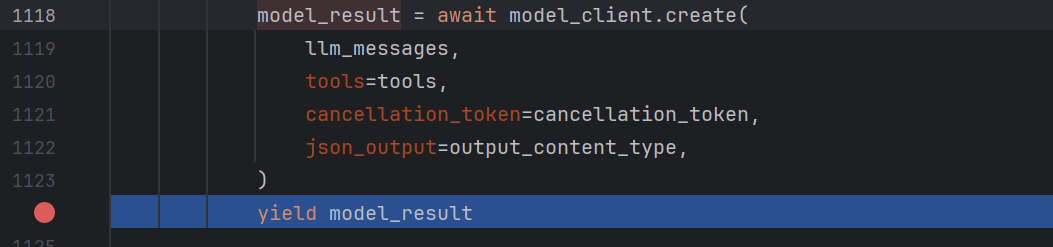

当调用工具的时候，观察该变量中的`content`，发现该列表确实只有一个工具调用的FunctionCall类的实例：

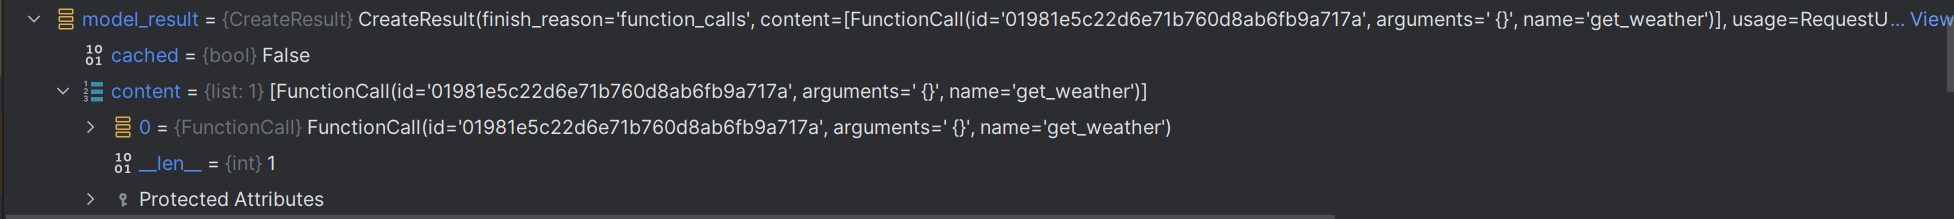

接下来我们让该输入函数2中，观察源代码，我们又发现该核心函数若调用了Tool，会直接将Tool执行的结果输出出来，而LLM_Client在整个过程中并没有输出其他的message内容：

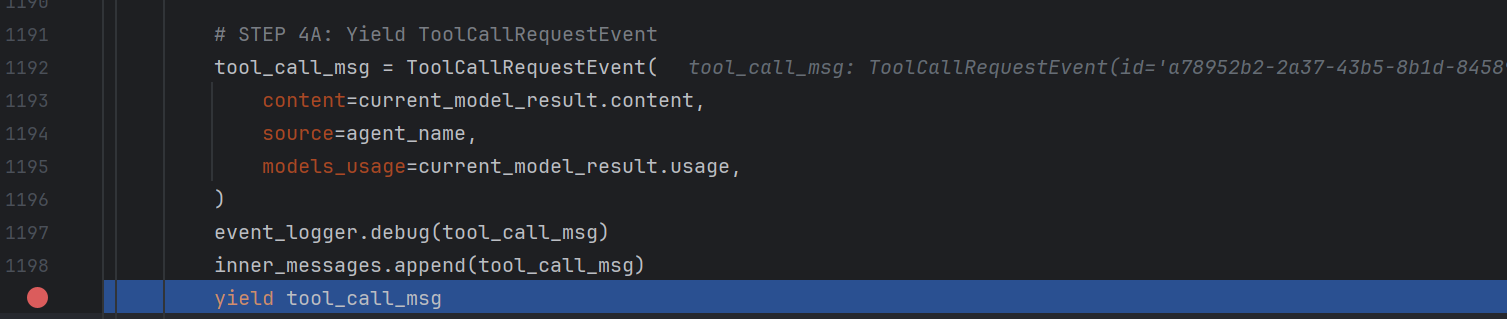

这就给我们提供了一个构建`只使用工具智能体`的思路，只有我们强制要求LLM_Client使用工具，就能使智能体输出的内容只包含工具输出内容。

由以上过程，我们知道，决定LLM_Client是否使用工具的主要有三部分:Task,Model_context,System_message，而其主要作用的是`Task`和`System_message`。所以构建思路有两个：

1. 尽可能的使传入任务符合工具的的作用。

2. 使用System_message强制要求智能体调用Tool。 

### 多模态输入

AssistantAgent 支持多模态输入，只需将输入封装为 `MultiModalMessage` 即可。  
这意味着你可以在一次消息中同时传递文本、图片、音频、视频等多种内容，Agent 会自动识别和处理。


关于 `MultiModalMessage` 的构建 参考 `1-Messages.ipynb`

调用多模态大模型，创建视觉助手 Agent。

我调用的是硅基流动平台的 API。

In [12]:
# 调用多模态大模型，创建视觉助手 Agent
import os
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent

load_dotenv()
siliconflow_api_key = os.getenv("SILICONFLOW_API_KEY") # 读取你的 OPENAI API key

# 初始化 OpenAIChatCompletionClient 客户端，连接到硅基流动平台的 Qwen3-8B 模型
vl_client = OpenAIChatCompletionClient(
    model="Pro/Qwen/Qwen2.5-VL-7B-Instruct",                # 指定要调用的模型名称，硅基流动平台上 Qwen 3-8B 模型
    base_url="https://api.siliconflow.cn/v1",  # 硅基流动平台的 API 访问地址
    api_key=siliconflow_api_key,  # 你的 API 密钥
    model_info={                        
        "family": "qwen",              
        "context_length": 8192,        
        "max_output_tokens": 2048,     
        "tool_choice_supported": True, 
        "tool_choice_required": False,  
        "structured_output": True,     
        "vision": True,                
        "function_calling": False,      
        "json_output": True           
    },
)

agent_vl = AssistantAgent(
    name="assistant",
    model_client=vl_client,
    system_message="你是一个乐于助人的中文助手。"
)

创建多模态消息


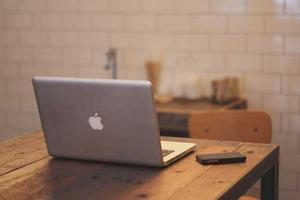

In [13]:
from io import BytesIO
import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# 步骤1：从网络下载一张随机图片，并用 PIL.Image 打开
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))

# 步骤2：将 PIL.Image 对象包装为 AutoGen 的 Image 对象
img = Image(pil_image)

# 步骤3：创建一个多模态消息，包含文本和图片
multi_modal_message = MultiModalMessage(
    content=["Can you describe the content of this image?", img],  # 同时包含文本和图片
    source="user"  # 消息来源
)

# img 变量现在是一个 AutoGen 的图片对象，可以用于多模态输入
img

得到多模态消息处理结果

In [14]:
# Use asyncio.run(...) when running in a script.
result = await agent_vl.run(task=multi_modal_message)
print(result.messages[-1].content)  # type: ignore


The image shows a clean and organized workspace. On a wooden table, there is a silver laptop with an Apple logo on its lid, resting on a larger display stand. To the right of the laptop, there is a black smartphone. The background shows a tiled wall with a white grout, which has a small sink and a stack of neatly arranged cups or bowls on a wooden shelf or counter. The ambiance of the image suggests a calm and modern environment, typically used for work or study.


### Streaming Messages **(Todo)**

你可以使用 `run_stream()` 方法实现消息(Message)的流式输出。这样，Agent 每生成一段内容就会立即返回，你可以实时处理和展示这些消息。

**说明：**
- `run_stream()` 返回一个异步生成器，每次生成一条消息。
- 适合需要实时展示模型输出的场景，比如聊天界面、命令行交互等。
- 要实现流式输出需要智能体在定义的时候显式声名

参考：https://microsoft.github.io/autogen/dev/user-guide/agentchat-user-guide/tutorial/agents.html#streaming-messages

In [15]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    async for message in agent_vl.run_stream(task=multi_modal_message):
        if isinstance(message, TextMessage):
            final_text = message.content
            print(final_text)

# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

This image shows a modern, minimalist setup on a wooden table. In the foreground, an open silver MacBook is placed on a stand, with its screen tilted slightly upwards. To the right of the laptop, there is a small black smartphone resting on the table. In the background, against a tiled wall with a rustic appearance, there is a blurred collection of items such as cups or mugs arranged neatly on what might be a shelf or table. The arrangement suggests a clean, organized, and possibly work-related or study setting.


In [17]:
##或者使用Console来显示所有的信息

async def assistant_run_stream_v1() -> None:
    await Console(
        agent_vl.run_stream(task=multi_modal_message),
        output_stats=True,  # Enable stats printing.
    )

# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream_v1()

---------- MultiModalMessage (user) ----------
Can you describe the content of this image?
<image>
---------- TextMessage (assistant) ----------
The image shows an open MacBook placed on a wooden table. The table surface is weathered with a warm, natural finish. The laptop's lid is open, revealing its screen, and the Apple logo is visible on the lid's surface. To the right of the laptop, a small black smartphone is placed. In the background, there is a blurred furniture setup that includes a chair and what appears to be a countertop or table with various kitchenware items. The walls in the background have a white-tiled appearance. The setting gives off a cozy, modern office or home workspace vibe.
[Prompt tokens: 516, Completion tokens: 118]
---------- Summary ----------
Number of messages: 2
Finish reason: None
Total prompt tokens: 516
Total completion tokens: 118
Duration: 2.52 seconds


### Using Tools and Workbench

大语言模型（LLM）本身通常只能生成文本或代码，但许多复杂任务需要调用外部工具（如 API、数据库等）来获取数据或执行操作。

#### 工具调用 Tool Calling / Function Calling

现代 LLM 支持“工具调用”能力：  
- 你可以为模型提供一组工具的描述（schema），模型会根据对话内容自动生成工具调用请求。
- 这种能力已成为智能体应用开发的主流模式（如 OpenAI、Anthropic 的 Function Calling）。


内置工具

Built-in Tools and Workbench

AutoGen Extension 提供了一系列内置工具（built-in tools），可以直接与 AssistantAgent 配合使用，极大扩展了智能体的能力。  
所有可用工具都在 `autogen_ext.tools` 命名空间下，具体工具和用法可参考 [API 文档](https://microsoft.github.io/autogen/dev/reference/python/autogen_ext.tools.html)。

---

常见内置工具示例

- **graphrag**：用于操作 GraphRAG 索引的工具，适合知识图谱和检索增强生成场景。

  参考链接：https://microsoft.github.io/autogen/dev/reference/python/autogen_ext.tools.graphrag.html#module-autogen_ext.tools.graphrag
  
- **http**：用于发起 HTTP 请求的工具，支持 GET、POST 等操作，适合联网获取数据。

    参考链接：https://microsoft.github.io/autogen/dev/reference/python/autogen_ext.tools.http.html#module-autogen_ext.tools.http

- **langchain**：适配 LangChain 工具生态，让 AutoGen 能直接调用 LangChain 的工具。

    参考链接：https://microsoft.github.io/autogen/dev/reference/python/autogen_ext.tools.langchain.html#module-autogen_ext.tools.langchain

- **mcp**：用于与 Model Chat Protocol (MCP) 服务器交互的工具和工作台，适合多模型协作和分布式智能体场景。

    参考链接：https://microsoft.github.io/autogen/dev/reference/python/autogen_ext.tools.mcp.html#module-autogen_ext.tools.mcp


#### Function Tool

`AssistantAgent` 会自动将 Python 函数转换为 FunctionTool，并根据函数签名和 docstring 自动生成工具 schema。  
这样你只需定义好 Python 函数，Agent 就能自动识别并调用，无需手动编写复杂的工具描述。

输出的 schema 会自动包含函数名、描述、参数类型等信息，供模型调用。


In [18]:
from autogen_core.tools import FunctionTool

# 定义一个工具函数
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."

# AssistantAgent 内部会自动完成这一步
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")
print(web_search_function_tool.schema)

{'name': 'web_search_func', 'description': 'Find information on the web', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'query', 'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'additionalProperties': False}, 'strict': False}


#### MCP Workbench（待完善）

AssistantAgent 还可以通过 `McpWorkbench()` 使用 MCP 服务器上的工具，实现跨进程、跨平台的工具调用。

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import McpWorkbench, StdioServerParams

# 配置 MCP 服务器
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])

# 创建 MCP 工作台并与 Agent 绑定
async with McpWorkbench(fetch_mcp_server) as workbench:
    model_client = OpenAIChatCompletionClient(model="gpt-4.1-nano")
    fetch_agent = AssistantAgent(
        name="fetcher", model_client=model_client, workbench=workbench, reflect_on_tool_use=True
    )

    # 让 Agent 使用 MCP 工具抓取网页内容并总结
    result = await fetch_agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
    print(result.messages[-1].content)
    await model_client.close()

#### Parallel Tool Calls（待完善）

部分模型支持**并行工具调用**，即一次对话中可同时调用多个工具。  
AssistantAgent 默认会并行调用所有工具（如果模型支持）。

- 如果你的工具有副作用或需要串行执行，可以在 model_client 层关闭并行调用。

In [ ]:
model_client_no_parallel_tool_call = OpenAIChatCompletionClient(
    model="gpt-4o",
    parallel_tool_calls=False,  # 禁用并行工具调用
)
agent_no_parallel_tool_call = AssistantAgent(
    name="assistant",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

### 结构化输出（待完善）

结构化输出允许模型根据你定义的 `Pydantic BaseModel` 类，返回结构化的 JSON 数据。这种方式比普通的 JSON-mode 更强大，因为你可以直接用 Python 类型校验和解析模型输出，方便集成到实际应用中。

- 你定义一个继承自 `pydantic.BaseModel` 的输出数据结构（schema）。
- 在创建 `AssistantAgent` 时，通过 `output_content_type` 参数指定这个 schema。
- Agent 回复时会自动生成一个 `StructuredMessage`，其 `content` 字段就是你定义的 BaseModel 类型对象。
- 你可以直接用 Python 代码访问和校验结构化内容。

In [ ]:
from typing import Literal
from autogen_agentchat.agents import AssistantAgent

from pydantic import BaseModel

# 定义 Agent 的结构化响应格式，继承自 Pydantic 的 BaseModel。
class AgentResponse(BaseModel):
    thoughts: str  # 思考过程
    response: Literal["happy", "sad", "neutral"]  # 只能是 happy、sad 或 neutral 之一

# 创建一个 Agent。
model_client = model_client
agent = AssistantAgent(
    "assistant",
    model_client=model_client,
    system_message="请按照 JSON 格式将输入分类为 happy、sad 或 neutral。",
    # 指定 Agent 的结构化输出类型。
    output_content_type=AgentResponse,
)

# 运行任务并流式输出结果
result = await Console(agent.run_stream(task="I am happy."))

# 检查最后一条消息类型，并打印思考内容和分类结果
assert isinstance(result.messages[-1], StructuredMessage)
assert isinstance(result.messages[-1].content, AgentResponse)
print("思考过程: ", result.messages[-1].content.thoughts)
print("分类结果: ", result.messages[-1].content.response)
await model_client.close()

## CustomAgent

在 AutoGen 中，如果你的需求不属于任何预设 Agent，可以通过继承 `BaseChatAgent` 来构建自定义 Agent。所有 Agent 都继承自 `BaseChatAgent`，并需要实现以下抽象方法和属性：


| 方法/属性                | 说明                                                                   | 是否必须实现 |
|--------------------------|-----------------------------------------------------------------------|--------------|
| `on_messages()`          | 定义 Agent 收到消息时的行为逻辑，返回 Response 对象。                     | 必须         |
| `on_reset()`             | 重置 Agent 状态到初始状态。                                              | 必须         |
| `produced_message_types` | 声明该 Agent 能产生的消息类型（BaseChatMessage 子类列表）。                 | 必须         |
| `on_messages_stream()`   | 支持流式输出时实现，边生成边返回消息。未实现时会用默认实现（调用 on_messages）。| 不必须 |


参考：https://microsoft.github.io/autogen/dev/user-guide/agentchat-user-guide/custom-agents.html#custom-agents

下面是一个定制 Agent 的例子。用于倒计时。

In [ ]:
from typing import AsyncGenerator, List, Sequence

from autogen_agentchat.agents import BaseChatAgent
from autogen_agentchat.base import Response
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage, TextMessage
from autogen_core import CancellationToken

# 定义一个自定义的倒计时 Agent
class CountDownAgent(BaseChatAgent):
    def __init__(self, name: str, count: int = 3):
        super().__init__(name, "一个简单的倒计时 Agent。")
        self._count = count

    @property
    def produced_message_types(self) -> Sequence[type[BaseChatMessage]]:
        # 声明该 Agent 只会产生 TextMessage 类型的消息
        return (TextMessage,)

    async def on_messages(self, messages: Sequence[BaseChatMessage], cancellation_token: CancellationToken) -> Response:
        # 调用 on_messages_stream 方法
        response: Response | None = None
        async for message in self.on_messages_stream(messages, cancellation_token):
            if isinstance(message, Response):
                response = message
        assert response is not None
        return response

    async def on_messages_stream(
        self, messages: Sequence[BaseChatMessage], cancellation_token: CancellationToken
    ) -> AsyncGenerator[BaseAgentEvent | BaseChatMessage | Response, None]:
        inner_messages: List[BaseAgentEvent | BaseChatMessage] = []
        for i in range(self._count, 0, -1):
            msg = TextMessage(content=f"{i}...", source=self.name)
            inner_messages.append(msg)
            yield msg
        # 最后返回 Response，包含最终消息和所有中间消息
        yield Response(chat_message=TextMessage(content="完成！", source=self.name), inner_messages=inner_messages)

    async def on_reset(self, cancellation_token: CancellationToken) -> None:
        # 可选：重置 Agent 状态
        pass

# 运行倒计时 Agent 的示例
async def run_countdown_agent() -> None:
    # 创建一个倒计时 Agent
    countdown_agent = CountDownAgent("countdown")

    # 运行 Agent，流式输出每条消息
    async for message in countdown_agent.on_messages_stream([], CancellationToken()):
        if isinstance(message, Response):
            print(message.chat_message)
        else:
            print(message)

# 在脚本中运行时请用 asyncio.run(run_countdown_agent())
await run_countdown_agent()